In [ ]:
!conda install -c conda-forge mlxtend

/bin/bash: conda: command not found


# Workflow
1. import necessary library
2. data ingestion
3. inspect data information
4. inspect null value
5. inspect duplicate
6. inspect data type to each column
7. impute missing value
8. train test split
9. building pipeline

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns

from scipy.stats import boxcox
from scipy.special import boxcox1p

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import SparsePCA,PCA,TruncatedSVD
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.metrics import mean_squared_error as MSE,r2_score as R2
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import FunctionTransformer
from mlxtend.preprocessing import DenseTransformer
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import tensorflow.keras as k

In [ ]:
df_train = pd.read_csv("/content/train.csv",sep=",")
df_test = pd.read_csv("/content/test.csv")
sample_sub = pd.read_csv("/content/sample_submission_V9Inaty.csv")
df_train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [ ]:
def inspect_missing(df):
    na_val = df.isnull().sum()/len(df) *100
    na_val = na_val.sort_values(ascending=False)
    na_val = na_val[na_val >0].to_frame(name='missing_percentage')
    return na_val

,missing_percentage
Product_Category_3,69.672659
Product_Category_2,31.566643


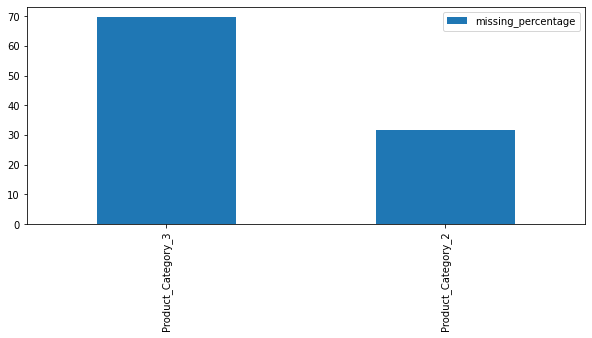

In [ ]:
#missing value percentage in dataset column
display(inspect_missing(df_train))
fig,ax = plt.subplots(figsize=(10,4))
inspect_missing(df_train).plot(kind='bar',ax=ax)

In [ ]:
#duplicate value check
df_train[df_train.duplicated()]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


In [ ]:
# inspecting data type (num,cat,ord)

def unique_number(df):
    nunique = dict()
    for col in df.columns:
        nunique[col] = df[col].nunique()
    return nunique

In [ ]:
unique_number(df_train)

{'Age': 7,
 'City_Category': 3,
 'Gender': 2,
 'Marital_Status': 2,
 'Occupation': 21,
 'Product_Category_1': 20,
 'Product_Category_2': 17,
 'Product_Category_3': 15,
 'Product_ID': 3631,
 'Purchase': 18105,
 'Stay_In_Current_City_Years': 5,
 'User_ID': 5891}

In [ ]:
df_train.corr()['Purchase']

User_ID               0.004716
Occupation            0.020833
Marital_Status       -0.000463
Product_Category_1   -0.343703
Product_Category_2   -0.209918
Product_Category_3   -0.022006
Purchase              1.000000
Name: Purchase, dtype: float64

## data type for each column
1. Age = ordinal
2. city category = cat
3. gender = cat
4. martial stat = cat
5. occupation = cat
6. stay in current city = ord
7. user id = cat
8. product id = cat
9. Product_Category_1 = num
10. prod category 2 = num
11. prod category 3 = num

In [ ]:
#separate column with respective data types
cat_column = ['City_Category','Gender','Marital_Status','Occupation','User_ID','Product_ID']
num_column = ['Product_Category_1','Product_Category_2','Product_Category_3']
ord_column = ['Age','Stay_In_Current_City_Years']
#determining the ordinal value in ordered manner, keep the information in correct way
age_ord = []
stay_year_ord = []

In [ ]:
for ord in df_train.Age.value_counts().sort_index().index:
    age_ord.append(ord)

for ord1 in df_train.Stay_In_Current_City_Years.value_counts().sort_index().index:
    stay_year_ord.append(ord1)

In [ ]:
#impute missing value 
df_train[num_column] = df_train[num_column].fillna(0) # 0 means not buying the product 

In [ ]:
df_train[cat_column] = df_train[cat_column].astype('category')
df_train[num_column] = df_train[num_column].astype('int64')

In [ ]:
# column dtypes are in proper format
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     550068 non-null  category
 1   Product_ID                  550068 non-null  category
 2   Gender                      550068 non-null  category
 3   Age                         550068 non-null  object  
 4   Occupation                  550068 non-null  category
 5   City_Category               550068 non-null  category
 6   Stay_In_Current_City_Years  550068 non-null  object  
 7   Marital_Status              550068 non-null  category
 8   Product_Category_1          550068 non-null  int64   
 9   Product_Category_2          550068 non-null  int64   
 10  Product_Category_3          550068 non-null  int64   
 11  Purchase                    550068 non-null  int64   
dtypes: category(6), int64(4), object(2)
memory usage: 29.8+ MB

In [ ]:
#splitting
X = df_train.drop('Purchase',axis=1)
y = df_train['Purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# straight of to modeling 
# building pipeling

num_ = Pipeline(steps=[
    ('num_impute',SimpleImputer(strategy='constant',fill_value=0)),
    ('scaler',StandardScaler())                   
])
#handle unknown must be error when drop is specified
cat_ = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
     ('ohe',OneHotEncoder(handle_unknown='ignore'))
])
ord_ = Pipeline(steps=[
    ('ord_impute',SimpleImputer(strategy='most_frequent')),
     ('ord_encoder',OrdinalEncoder(categories=[age_ord,stay_year_ord]))
])

preprocessing = ColumnTransformer(transformers=[
                                                ('cat',cat_,cat_column),
                                                ('num',num_,num_column),
                                                ('ord',ord_,ord_column)
])

model_pipe = Pipeline(steps=[
                             ('preprocess',preprocessing),
                             ('dim_reduce',TruncatedSVD(n_components=100)),
                             ('to_dense',DenseTransformer()),
                             ('gboost',GradientBoostingRegressor(learning_rate=0.05))
])
#with scaler in the later pipe, it will cause error due to the entire data sparsity.
#this error can be tackled by passing argument with_mean=False into standard scaler
#or ones can put the scaler on the num transformer

In [ ]:
param_grid = {'gboost__max_features':['log2'],'gboost__n_estimators':[150,200,250]}
search = GridSearchCV(model_pipe,param_grid=param_grid)
#search.fit(X_train,y_train)

In [ ]:
#search.best_params_
#search.best_score_
3search.best_estimator_.named_steps.dim_reduce.explained_variance_

AttributeError: ignored

In [ ]:
search.best_score_

In [ ]:
y_pred = search.predict(X_test)
test_rmse = np.sqrt(MSE(y_test,y_pred))
test_r2 = R2(y_test,y_pred)
print(test_rmse)
print(test_r2)

In [ ]:
from joblib import dump,load

#this model is random guessing
filename = 'GBoost_model.joblib'
dump(search,filename)

In [ ]:
test_data_pred = search.predict(df_test)
df_test['Purchase'] = test_data_pred

In [ ]:
df_test.head()

In [ ]:
submit_attempt1 = df_test[['Purchase','User_ID','Product_ID']]
submit_attempt1.to_csv('attempt1_prediction.csv',index=False,index_label=False)

# Attempt 2 with different feature inputs

In [ ]:
X2 = X.drop(['User_ID','Product_ID'],axis=1).copy()
#separate column with respective data types
cat_column = ['City_Category','Gender','Marital_Status','Occupation']
num_column = ['Product_Category_1','Product_Category_2','Product_Category_3']
ord_column = ['Age','Stay_In_Current_City_Years']
#determining the ordinal value in ordered manner, keep the information in correct way
age_ord = []
stay_year_ord = []

for ord in df_train.Age.value_counts().sort_index().index:
    age_ord.append(ord)

for ord1 in df_train.Stay_In_Current_City_Years.value_counts().sort_index().index:
    stay_year_ord.append(ord1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.1, random_state=42)

In [ ]:
num_transformer = Pipeline(steps=[
                                  ('num_impute',SimpleImputer(strategy='constant',fill_value=0)),
                                  ('scaler',StandardScaler(with_mean=True))
])
cat_transformer = Pipeline(steps=[
                                  ('cat_impute',SimpleImputer(strategy='most_frequent')),
                                  ('ohe',OneHotEncoder(drop='first',handle_unknown='error'))
])
ord_transformer = Pipeline(steps=[
                                  ('ord_impute',SimpleImputer(strategy='most_frequent')),
                                  ('ord_encode',OrdinalEncoder(categories=[age_ord,stay_year_ord]))
])
preprocessing2 = ColumnTransformer(transformers=[
                                                 ('cat',cat_transformer,cat_column),
                                                 ('num',num_transformer,num_column),
                                                 ('ord',ord_transformer,ord_column)
])

model2_pipe = Pipeline(steps=[
                              ('preprocess',preprocessing2),
                              ('todense',DenseTransformer()),
                              ('rfr',RandomForestRegressor(max_features=0.3))
])


In [ ]:
param_grid2 = {'rfr__n_estimators':[150,350,420]}
search2 = GridSearchCV(model2_pipe,param_grid=param_grid2)
#search2.fit(X_train2,y_train2)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [ ]:
search2.best_score_

0.6346081608468008

In [ ]:
search2.best_params_

{'rfr__n_estimators': 420}

In [ ]:
from joblib import load,dump
filename2 = 'gboost attempt2.joblib'
dump(search2,filename2)

['gboost attempt2.joblib']

In [ ]:
y_pred2 = search2.predict(X_test2)
test2_rmse = np.sqrt(MSE(y_test2,y_pred2))
test2_r2 = R2(y_test2,y_pred2)
print(test2_rmse)
print(test2_r2)

3038.855455375126
0.6320853288436934


In [ ]:
test2_data_pred = search2.predict(df_test.drop(['User_ID','Product_ID'],axis=1))
df_test['Purchase'] = test2_data_pred

In [ ]:
df_test

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN,18110.016423
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN,10489.537472
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN,8359.213952
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN,2564.282131
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0,3084.184404
...,...,...,...,...,...,...,...,...,...,...,...,...
233594,1006036,P00118942,F,26-35,15,B,4+,1,8,NaN,NaN,6763.016421
233595,1006036,P00254642,F,26-35,15,B,4+,1,5,8.0,NaN,5733.285234
233596,1006036,P00031842,F,26-35,15,B,4+,1,1,5.0,12.0,11489.799345
233597,1006037,P00124742,F,46-50,1,C,4+,0,10,16.0,NaN,21311.103280


In [ ]:
to_submit2 = df_test[['Purchase','User_ID','Product_ID']]
to_submit2.to_csv('attempt2_prediction_colabs_63.csv',index=False,index_label=False)

# attempt 3 the deep learning

(array([383247.,      0.,      0.,      0.,    613.,   1875.,  21548.,
         24141.,  18236., 100408.]),
 array([0.        , 0.2944439 , 0.5888878 , 0.88333169, 1.17777559,
        1.47221949, 1.76666339, 2.06110729, 2.35555118, 2.64999508,
        2.94443898]),
 <a list of 10 Patch objects>)

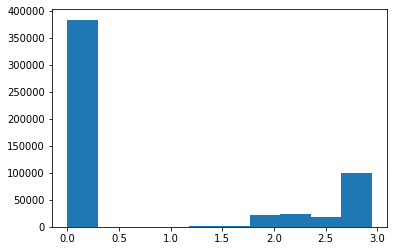

In [181]:
prod1 = df_train['Product_Category_1'].fillna(np.mean(df_train['Product_Category_1']))
prod2 = df_train['Product_Category_2'].fillna(np.mean(df_train['Product_Category_2']))
prod3 = df_train['Product_Category_3'].fillna(np.mean(df_train['Product_Category_3']))

prod1_t = np.log1p(prod1) #apply log transform
prod2_t = np.log1p(prod2)
prod3_t = np.log1p(prod3)
#fig,(ax,ax2,ax3)= plt.subplots(1,3,figsize=(12,6))
#prod1_t.plot(ax=ax,kind='hist')
#prod2.plot(ax=ax2,kind='hist')
#prod3.plot(ax=ax3,kind='hist')
plt.hist(prod3_t)
#prod1_t


In [191]:
def base_model():
    model = Sequential()
    model.add(Dense(256,kernel_initializer='normal',input_dim= 29, activation='relu'))
    model.add(Dense(256,kernel_initializer='normal',activation='relu'))
    model.add(Dense(256,kernel_initializer='normal',activation='relu'))
    model.add(Dense(256,kernel_initializer='normal',activation='relu'))
    model.add(Dense(128,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    opt = k.optimizers.Adam(lr=0.001,epsilon=1e-08)
    model.compile(optimizer=opt,loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [185]:
X2['Product_Category_1'] = X2['Product_Category_1'].fillna(np.mean(X2['Product_Category_1']))
X2['Product_Category_2'] = X2['Product_Category_2'].fillna(np.mean(X2['Product_Category_2']))
X2['Product_Category_3'] = X2['Product_Category_3'].fillna(np.mean(X2['Product_Category_3']))
X2['Product_Category_1'] = np.log1p(X2['Product_Category_1'])

In [194]:
# pipeline 
num_ = Pipeline(steps=[
                       ('num_impute',SimpleImputer(strategy='mean')),
                       ('scaler',StandardScaler())
])
cat_ = Pipeline(steps=[
                       ('cat_impute',SimpleImputer(strategy='most_frequent')),
                       ('ohe',OneHotEncoder(drop='first'))
])
ord_ = Pipeline(steps=[
                       ('ord_impute',SimpleImputer(strategy='most_frequent')),
                       ('ore',OrdinalEncoder(categories=[age_ord,stay_year_ord]))
])

preprocess = ColumnTransformer(transformers=[
                                             ('cat_col',cat_,cat_column),
                                             ('num_col',num_,num_column),
                                             ('ord_col',ord_,ord_column)
])

model_pipe = Pipeline(steps=[
                             ('prep',preprocess),
                             ('todense',DenseTransformer()),
                             ('toarray',FunctionTransformer(np.asarray,kw_args={'dtype':np.float32})),#convert to float34 is mandatory to use DL
                             ('keras',KerasRegressor(build_fn=base_model,epochs=100,batch_size=32,validation_split=0.05))
])

In [195]:
base_model().summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 256)               7680      
_________________________________________________________________
dense_127 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_128 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_129 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_130 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 129       
Total params: 238,081
Trainable params: 238,081
Non-trainable params: 0
_______________________________________________

In [196]:
history = model_pipe.fit(X2,y)

Epoch 1/100
16331/16331 [==============================] - 96s 6ms/step - loss: 19008827.5790 - root_mean_squared_error: 4328.0086 - val_loss: 51417120.0000 - val_root_mean_squared_error: 7170.5732
Epoch 2/100
16331/16331 [==============================] - 86s 5ms/step - loss: 10820936.4353 - root_mean_squared_error: 3288.7194 - val_loss: 10053758.0000 - val_root_mean_squared_error: 3170.7661
Epoch 3/100
16331/16331 [==============================] - 90s 6ms/step - loss: 9471683.2801 - root_mean_squared_error: 3077.5996 - val_loss: 9277094.0000 - val_root_mean_squared_error: 3045.8323
Epoch 4/100
16331/16331 [==============================] - 81s 5ms/step - loss: 9316851.4692 - root_mean_squared_error: 3052.3229 - val_loss: 8993503.0000 - val_root_mean_squared_error: 2998.9170
Epoch 5/100
16331/16331 [==============================] - 82s 5ms/step - loss: 9143751.4033 - root_mean_squared_error: 3023.8513 - val_loss: 9272892.0000 - val_root_mean_squared_error: 3045.1423
Epoch 6/100
1633

In [197]:
test2_data_pred = history.predict(df_test.drop(['User_ID','Product_ID'],axis=1))
df_test['Purchase'] = test2_data_pred

In [198]:
df_test

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN,12568.122070
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN,6386.706543
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN,19989.578125
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN,12801.713867
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0,12387.993164
...,...,...,...,...,...,...,...,...,...,...,...,...
233594,1006036,P00118942,F,26-35,15,B,4+,1,8,NaN,NaN,38331.097656
233595,1006036,P00254642,F,26-35,15,B,4+,1,5,8.0,NaN,19210.599609
233596,1006036,P00031842,F,26-35,15,B,4+,1,1,5.0,12.0,9592.395508
233597,1006037,P00124742,F,46-50,1,C,4+,0,10,16.0,NaN,51592.253906


In [201]:
to_submit3 = df_test[['Purchase','User_ID','Product_ID']]
to_submit3.to_csv('attempt3_prediction_colabs_dl.csv',index=False,index_label=False)

In [202]:
import joblib
import pickle

In [208]:
to_submit3

,Purchase,User_ID,Product_ID
0,12568.122070,1000004,P00128942
1,6386.706543,1000009,P00113442
2,19989.578125,1000010,P00288442
3,12801.713867,1000010,P00145342
4,12387.993164,1000011,P00053842
...,...,...,...
233594,38331.097656,1006036,P00118942
233595,19210.599609,1006036,P00254642
233596,9592.395508,1006036,P00031842
233597,51592.253906,1006037,P00124742


In [207]:
filename= "NN pipeline and architecture.joblib"
filename2 = "NN pipeline and architecture.sav"
joblib.dump(history,filename)
#pickle.dump(history.predict,filename2)

TypeError: ignored

In [ ]:
sample_sub

,Purchase,User_ID,Product_ID
0,100,1000004,P00128942
1,100,1000009,P00113442
2,100,1000010,P00288442
3,100,1000010,P00145342
4,100,1000011,P00053842
...,...,...,...
233594,100,1006036,P00118942
233595,100,1006036,P00254642
233596,100,1006036,P00031842
233597,100,1006037,P00124742
